In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits import basemap
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

## What are we going to do?
At our disposal we have values of air pressure and 500 hPa geopotential height measured daily at geographic points (moreless) evenly distributed on earth. We also have values of different variables, such as average daily temperature or rainfall in exactly one location of interest - Warsaw, Poland. 

Our goal is to find geographic points and exact variables (air pressure vs. geopotential height), which correlate the most with the variables values of which we have measured for Warsaw (well, except Warsaw itself maybe). In doing so, we hope to find some non-local patterns that we could leverage in short term weather prediction.

In [17]:
# Let's get the data and take a look.
meteo_w = pd.read_csv('./data/meteo_W.csv', sep=';', index_col=0, parse_dates=True)
print(meteo_w.head(3))

            Longitude   Latitude   TSRED       OPAD     WIATR     SOLAR
DATA                                                                   
2001-01-01    20.9375  52.298302 -2.0530   0.925255  3.969874  1.475437
2001-01-02    20.9375  52.298302 -2.2615   7.479287  3.911959  1.899621
2001-01-03    20.9375  52.298302  0.5690  10.250768  2.457609  0.937744


So we can see that we have values of:
  * average temperature
  * daily rainfall
  * average wind speed
  * insolation

for some number of days in the same location - that is, Warsaw.

In [18]:
p_slp = pd.read_csv('./data/P_SLP_-60_80-90_90-0115.csv', sep=';', index_col=0) # air pressure 
p_slp.tail(3)

,latitude,longitude,2001_01_01_00,2001_01_02_00,2001_01_03_00,2001_01_04_00,2001_01_05_00,2001_01_06_00,2001_01_07_00,2001_01_08_00,...,2015_12_22_00,2015_12_23_00,2015_12_24_00,2015_12_25_00,2015_12_26_00,2015_12_27_00,2015_12_28_00,2015_12_29_00,2015_12_30_00,2015_12_31_00
4159,80.0,85.0,1041.3,1037.1,1032.5,1023.2,1018.2,1011.3,1012.4,1021.4,...,987.5,970.7,977.0,994.4,980.8,983.9,997.9,1021.0,1020.7,1010.2
4160,80.0,87.5,1041.6,1037.7,1033.2,1025.1,1019.5,1012.1,1012.9,1022.0,...,989.4,971.7,975.8,994.5,981.5,985.3,997.8,1020.6,1020.9,1009.4
4161,80.0,90.0,1041.9,1038.3,1033.8,1026.8,1020.6,1012.9,1013.4,1022.4,...,991.2,972.9,974.7,994.3,982.0,986.6,997.7,1020.0,1021.0,1008.7


Here we have measurements of air pressure in hPa for some number of days in some number of locations. 

In [19]:
p_hgt = pd.read_csv('./data/P_HGT_-60_80-90_90-0115.csv', sep=';', index_col=0) # geopotential height
p_hgt.head(3)

,latitude,longitude,2001_01_01_00,2001_01_02_00,2001_01_03_00,2001_01_04_00,2001_01_05_00,2001_01_06_00,2001_01_07_00,2001_01_08_00,...,2015_12_22_00,2015_12_23_00,2015_12_24_00,2015_12_25_00,2015_12_26_00,2015_12_27_00,2015_12_28_00,2015_12_29_00,2015_12_30_00,2015_12_31_00
1,-60.0,-90.0,5.215,5.138,5.144,5.226,5.241,5.175,5.172,5.178,...,5.219,5.186,5.158,5.337,5.425,5.470,5.326,5.250,5.248,5.207
2,-60.0,-87.5,5.194,5.138,5.126,5.214,5.240,5.173,5.162,5.179,...,5.190,5.172,5.130,5.295,5.385,5.439,5.314,5.246,5.265,5.245
3,-60.0,-85.0,5.173,5.143,5.109,5.195,5.239,5.174,5.157,5.181,...,5.166,5.161,5.108,5.257,5.350,5.405,5.302,5.242,5.275,5.282


And here we have analogous data but the values are of 500 hPa geopotential height.

***

## Let's transform the data a little.

In [20]:
# We drop the location from the first DF - it's Warsaw anyway.
meteo_w = meteo_w.drop(['Latitude', 'Longitude', 'WIATR', 'SOLAR'], axis=1)

In [21]:
# Now let's convert the remaining dataframes to similar format.
index_columns = ['latitude', 'longitude']

# Check if geographical locations match.
index = p_hgt.loc[:, index_columns]
assert index.equals(p_slp.loc[:, index_columns])

# Transpose and check if indices match.
p_hgt = p_hgt.drop(index_columns, axis=1).transpose()
p_slp = p_slp.drop(index_columns, axis=1).transpose()

# Add geographic locations MultiIndex as columns.
tuples = zip(index["latitude"], index["longitude"])
index = pd.MultiIndex.from_tuples(tuples, names=['latitude', 'longitude'])
p_hgt.columns = p_slp.columns = index

# Get proper dates in the index.
p_hgt.index = pd.to_datetime(p_hgt.index, format="%Y_%m_%d", exact=False)
p_slp.index = pd.to_datetime(p_slp.index, format="%Y_%m_%d", exact=False)
assert p_hgt.index.equals(p_slp.index)

# Intersect the dates.
common_index = meteo_w.index.intersection(p_hgt.index)
meteo_w = meteo_w.loc[common_index]
p_hgt = p_hgt.loc[common_index]
p_slp = p_slp.loc[common_index]

In [22]:
# So what do we have?
meteo_w.info()
meteo_w.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4960 entries, 2001-01-01 to 2014-07-31
Freq: D
Data columns (total 2 columns):
TSRED    4960 non-null float64
OPAD     4960 non-null float64
dtypes: float64(2)
memory usage: 116.2 KB


,TSRED,OPAD
2001-01-01,-2.0530,0.925255
2001-01-02,-2.2615,7.479287
2001-01-03,0.5690,10.250768
2001-01-04,0.7725,2.617835
2001-01-05,0.7560,1.144123


In [23]:
p_hgt.info()
p_hgt.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4960 entries, 2001-01-01 to 2014-07-31
Freq: D
Columns: 4161 entries, (-60.0, -90.0) to (80.0, 90.0)
dtypes: float64(4161)
memory usage: 157.5 MB


latitude    -60.0                                                          \
longitude   -90.0  -87.5  -85.0  -82.5  -80.0  -77.5  -75.0  -72.5  -70.0   
2001-01-01  5.215  5.194  5.173  5.153  5.134  5.118  5.105  5.094  5.087   
2001-01-02  5.138  5.138  5.143  5.149  5.154  5.156  5.156  5.152  5.145   
2001-01-03  5.144  5.126  5.109  5.093  5.079  5.070  5.066  5.070  5.080   
2001-01-04  5.226  5.214  5.195  5.173  5.148  5.125  5.106  5.095  5.092   
2001-01-05  5.241  5.240  5.239  5.238  5.238  5.238  5.237  5.236  5.234   

latitude           ...     80.0                                            \
longitude   -67.5  ...     67.5   70.0   72.5   75.0   77.5   80.0   82.5   
2001-01-01  5.083  ...    5.251  5.254  5.257  5.260  5.263  5.266  5.268   
2001-01-02  5.136  ...    5.196  5.197  5.199  5.201  5.203  5.205  5.208   
2001-01-03  5.096  ...    5.191  5.190  5.187  5.185  5.182  5.179  5.177   
2001-01-04  5.097  ...    5.161  5.159  5.158  5.157  5.156  5.154  5.153   
2001-01-05  5.229  ...    5.265  5.265  5.263  5.260  5.256  5.250  5.244   

latitude                         
longitude    85.0   87.5   90.0  
2001-01-01  5.271  5.275  5.278  
2001-01-02  5.212  5.216  5.221  
2001-01-03  5.176  5.175  5.176  
2001-01-04  5.152  5.152  5.151  
2001-01-05  5.236  5.228  5.219  

[5 rows x 4161 columns]

In [24]:
p_slp.info()
p_slp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4960 entries, 2001-01-01 to 2014-07-31
Freq: D
Columns: 4161 entries, (-60.0, -90.0) to (80.0, 90.0)
dtypes: float64(4161)
memory usage: 157.5 MB


latitude    -60.0                                                          \
longitude   -90.0  -87.5  -85.0  -82.5  -80.0  -77.5  -75.0  -72.5  -70.0   
2001-01-01  995.5  993.8  992.4  991.1  989.4  987.6  985.7  984.1  983.1   
2001-01-02  990.7  990.5  990.5  990.5  990.3  989.9  989.7  989.5  989.5   
2001-01-03  990.3  989.1  987.7  986.0  984.0  982.3  981.2  980.8  980.7   
2001-01-04  993.2  993.5  993.2  992.2  990.6  988.7  986.8  985.2  984.0   
2001-01-05  990.4  990.6  991.0  991.3  991.6  991.9  992.4  992.9  993.4   

latitude            ...      80.0                                          \
longitude   -67.5   ...      67.5    70.0    72.5    75.0    77.5    80.0   
2001-01-01  983.0   ...    1037.4  1038.2  1039.0  1039.6  1040.1  1040.6   
2001-01-02  989.6   ...    1032.1  1033.1  1033.9  1034.6  1035.3  1035.9   
2001-01-03  980.6   ...    1024.8  1026.3  1027.6  1028.8  1029.9  1030.8   
2001-01-04  983.6   ...    1011.2  1012.4  1013.9  1015.6  1017.4  1019.3   
2001-01-05  993.9   ...    1009.3  1010.4  1011.7  1012.9  1014.2  1015.6   

latitude                                    
longitude     82.5    85.0    87.5    90.0  
2001-01-01  1040.9  1041.3  1041.6  1041.9  
2001-01-02  1036.5  1037.1  1037.7  1038.3  
2001-01-03  1031.7  1032.5  1033.2  1033.8  
2001-01-04  1021.3  1023.2  1025.1  1026.8  
2001-01-05  1016.9  1018.2  1019.5  1020.6  

[5 rows x 4161 columns]

## On to correlations, finally.

In [25]:
def correlate_columns(a: pd.Series, b: pd.Series, start: int = 0, end: int = 5000):
    return a.iloc[start:end].corr(b.iloc[start:end])

# Choose what we actually want to compare.
meteo_w_var = "TSRED"
p_var = p_hgt

correlations = pd.DataFrame(np.zeros((1, p_var.shape[1])))
correlations.columns = p_var.columns

for col in correlations:
    correlations.loc[0, col] = correlate_columns(meteo_w[meteo_w_var], p_var[col])

In [26]:
# Get them correlations.
# Below code is inspired by the awesome https://github.com/erikbern/ping repository.
X = np.arange(-90, 90.1, 2.5)
Y = np.arange(-60, 80.1, 2.5)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
for i, _ in np.ndenumerate(X):
    Z[i] = correlations.loc[0, (Y[i], X[i])]

In [27]:
# And let's find, say, 5 most extreme values.
arg_max = np.argsort(np.abs(Z).ravel())[-3:]
lons = [X.ravel()[i] for i in arg_max]
lats = [Y.ravel()[i] for i in arg_max]

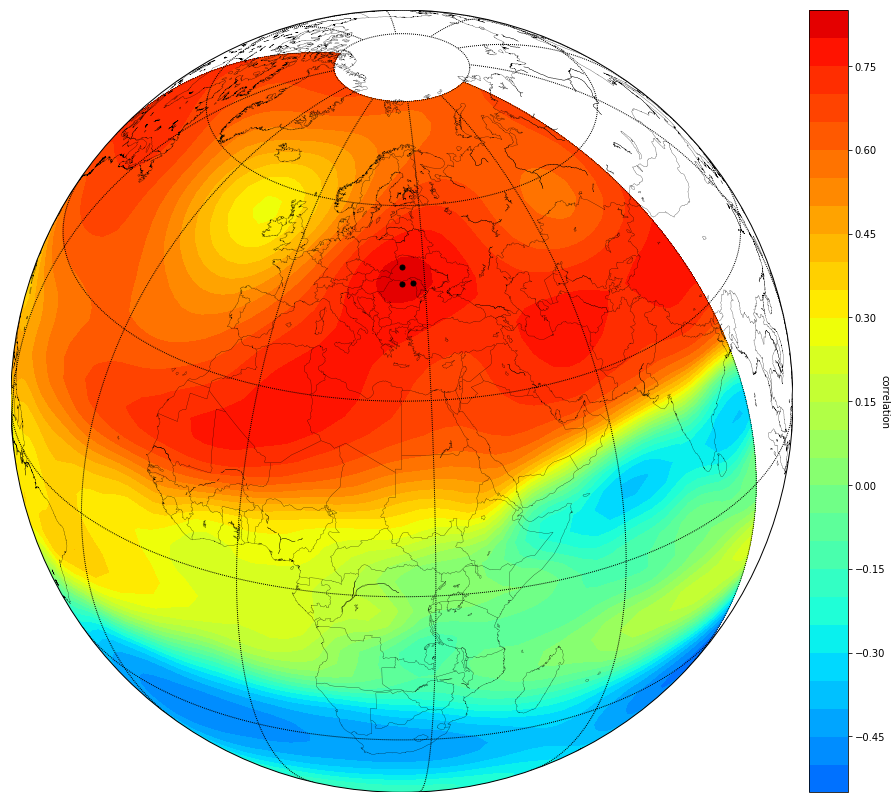

In [28]:
map = basemap.Basemap(projection='ortho',lat_0=30, lon_0=lons[-1],resolution='l')
plt.figure(figsize=(15, 15))

# Draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)

# Draw lon/lat grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# Fill the map.
cf = map.contourf(X, Y, Z, 30, cmap=plt.get_cmap('jet'), norm=plt.Normalize(vmin=-1, vmax=1), latlon=True)
cbar = map.colorbar(cf)
cbar.set_label('correlation', rotation=270)

# Plot the extreme points.
x, y = map(lons, lats)
map.plot(x, y, marker='.', color='0', markersize=10, linewidth=0)

plt.show()